# Implementation of Algorithm

Note that standard numpy implementations are used for finding roots and calculating eigenvectors, which differ from the methods given in the paper. Any algorithm for these steps can be pasted into this notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

# Note: edit this to implement a polynomial root finder of your choice
def root_finder(c):
  """
  Finds roots of the polynomial::

    c[0] * x**n + c[1] * x**(n-1) + ... + c[n-1]*x + c[n]
  """
  return np.roots(c)

# Note: edit this to implement a different eigenvector solver
def eigenvectors(H):
  """
  Compute the eigenvalues and right eigenvectors of a square array.
  """
  return LA.eig(H)

def moment(x, pi, n):
  """
  Returns the nth moment given model parameters.
  Input: pi gives the probabilities of sources (states of U).
  x gives the probability of the Bernoulli RV for each state of U.
  Output: nth moment
  """
  return np.dot(pi, x**n)

def Hankel(x, pi):
  """
  Calculates the model Hankel matrix given model parameters.
  Input: pi gives the probabilities of sources (states of U).
  x gives the probability of the Bernoulli random variables for each state of U.
  Output: Hankel matrix of size (k+1) x (k+1)
  """
  k = len(x)
  result = np.zeros((k+1, k+1))
  for i in range(k+1):
    for j in range(k+1):
      m = i + j
      result[i, j] = moment(x, pi, m)
  return result

def empirical_moment(data, m):
  """
  Calculates an empirical estimate for the mth moment given data.
  Input: Data is a list of at least m samples of a Bernoulli random variable.
  m is the order of the desired moment.
  Output: mth moment
  """
  # Count frequency of seeing 1s for first m entries
  all_ones = [np.prod(sample[:m]) for sample in data]
  return np.mean(all_ones)

def empirical_Hankel(data, k):
  """
  Calculates an empirical Hankel matrix.
  Input: Data is a list of at least m samples of a Bernoulli random variable.
  k is the assumed support.
  Output: Hankel matrix of size (k+1) x (k+1)
  """
  result = np.zeros((k+1, k+1))
  moments = [empirical_moment(data, m) for m in range(2*k + 1)]
  for i in range(k+1):
    for j in range(k+1):
      m = i + j
      result[i, j] = moments[m]
  return result

def Vandermonde(x, k):
  """
  Returns a matrix with all 1s for the first row, x for second row,
  x^2 elementwise for the third row, etc for k rows
  """
  return np.array([np.array(x)**i for i in range(k)])

# Main algorithm
def recover_spikes(data, k):
  """
  Calculates an empirical estimate for the mth moment given data.
  Input: Data is a list of at least m samples of a Bernoulli random variable.
  k is the order of the support/number of sources.
  Output: pi gives the probabilities of the sources (states of U)
  x gives the probabilities of the Bernoulli random variables.
  """
  H = empirical_Hankel(data, k)
  w, v = LA.eig(H)

  # Find probabilities of Bernoulli
  smallest_eigenvector = v.T[-1]
  coefficient_list = list(smallest_eigenvector)
  coefficient_list.reverse()
  x = root_finder(coefficient_list)
  print("Roots of polynomial found at: {}".format(x))

  # Find probabilities of sources
  moments = [empirical_moment(data, m) for m in range(k)]
  V = Vandermonde(x, k)
  V_inv = LA.inv(V)
  pi = np.matmul(V_inv, moments)
  print("Probability of sources: {}".format(pi))
  return pi, x

# Implementation including plots of polynomial and spikes

This implementation is not for use, but gives a nice visualization of the polynomial given by the kernel of the Hankel matrix. The true model is plotted with black spikes, and the reconstructed one is plotted with blue spikes.

In [ ]:
# Code for plotting steps
def plot_spikes(x, pi, col):
  plt.axhline(y=0, xmin=0, xmax=1, linewidth=1, color = 'k')
  for x_i, pi_i in zip(x, pi):
    plt.axvline(x=x_i, ymin=0, ymax = pi_i, linewidth=2, color=col)

def poly(coefs, x):
  result = 0.0
  coefs = list(coefs)
  coefs.reverse()
  for i, c in enumerate(coefs):
    result += c * (x**i)
  return result

def plot_polynomial(coefs, label):
  xs = [i/1000.0 for i in range(1000)]
  ys = [poly(coefs, x) for x in xs]
  plt.plot(xs, ys, label = str(label))

def recover_spikes_plots(x_true, pi_true, data, k):
  H = empirical_Hankel(data, k)
  w, v = LA.eig(H)
  print(H)

  # Find probabilities of Bernoulli
  smallest_eigenvector = v.T[-1]
  coefficient_list = list(smallest_eigenvector)
  coefficient_list.reverse()
  x = root_finder(coefficient_list)

  # Find probabilities of sources
  moments = [empirical_moment(data, m) for m in range(k)]
  V = Vandermonde(x, k)
  V_inv = LA.inv(V)
  pi = np.matmul(V_inv, moments)

  # Add plot of polynomial from true Hankel matrix for comparison
  H_true = Hankel(x_true, pi_true)
  print(H_true)
  w, v = LA.eig(H_true)
  print("Smallest Eigenvalue: {}".format(w[-1]))
  smallest_eigenvector = v.T[-1]
  coefficient_list_true = list(smallest_eigenvector)
  coefficient_list_true.reverse()

  plot_spikes(x_true, pi_true, 'k')
  plot_spikes(x, pi, 'b')
  plot_polynomial(coefficient_list, "Kernel Polynomial for Empirical Hankel Matrix")
  plot_polynomial(coefficient_list_true, "Kernel Polynomial for True Hankel Matrix")
  plt.legend()

  H_recon = Hankel(x, pi)
  print(H_recon)

  print("Roots of polynomial found at: {}".format(x))
  print("Probability of sources: {}".format(pi))
  return pi, x


# Testing
The following code generates data and tests the algorithm


Data Generated
[[1.       0.500317 0.29357  0.190302]
 [0.500317 0.29357  0.190302 0.130845]
 [0.29357  0.190302 0.130845 0.0928  ]
 [0.190302 0.130845 0.0928   0.067168]]
[[1.         0.5        0.29375    0.190625  ]
 [0.5        0.29375    0.190625   0.13085938]
 [0.29375    0.190625   0.13085938 0.09277344]
 [0.190625   0.13085938 0.09277344 0.06706543]]
Smallest Eigenvalue: 4.946276061488736e-18
[[1.         0.500317   0.29357    0.19030896]
 [0.500317   0.29357    0.19030896 0.13078882]
 [0.29357    0.19030896 0.13078882 0.09289598]
 [0.19030896 0.13078882 0.09289598 0.06719014]]
Roots of polynomial found at: [0.73869284 0.39027488 0.18305827]
Probability of sources: [0.40375788 0.44840469 0.14783744]


(array([0.40375788, 0.44840469, 0.14783744]),
 array([0.73869284, 0.39027488, 0.18305827]))

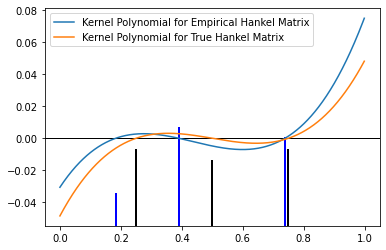

In [ ]:
import random

# Model Specifications
k = 3
x = np.array([.25, .5, .75])
pi = np.array([.35, .3, .35])
N = 1000000 # Number of samples

data = []
for i in range(N):
  p = random.choices(x, weights=pi)[0]
  # Draw 2k samples from given p
  data.append(np.random.binomial(1, p, 2*k + 1))
data = np.array(data)
print('Data Generated')

# Use this line if you want the plots of the polynomial
recover_spikes_plots(x, pi, data, k)
# Use this line if you just want to reconstruct the model
#recover_spikes(data, k)
